In [1]:
import numpy as np
import matplotlib.pyplot as plt
import deeptime

In [2]:
#plotting

def plot_synthetic_landscapes(xi_all, pi_all, e_all, pi_all_out, box_min, box_max, minima_coords, plot_p=False, plot_e=False, plot_e_out=False, plot_hist=False, plot_states=False):
    
    if plot_p:
        if plot_hist:
            plt.hist2d([i[0] for i in xi_all], [i[1] for i in xi_all], weights = pi_all, bins = [40,40], range=[[box_min[0],box_max[0]],[box_min[1],box_max[1]]])
            for mc in minima_coords:
                plt.scatter(mc[0], mc[1])
            plt.axis("equal")
            plt.show()

        if plot_states:
            plt.scatter([i[0] for i in xi_all], [i[1] for i in xi_all], c=pi_all, cmap='viridis')
            plt.axis("equal")
            #plt.size([box_max[0]-box_min[0], box_max[1]-box_min[1]])
            plt.show()

    if plot_e:
        #histograms of energies are a bad idea because adding positive energies makes the state appear higher in energy when it is actually lower
        # if plot_hist:
        #     plt.hist2d([i[0] for i in xi_all], [i[1] for i in xi_all], weights = e_all, bins = [40,40], range=[[box_min[0],box_max[0]],[box_min[1],box_max[1]]])
        #     for mc in minima_coords:
        #         plt.scatter(mc[0], mc[1])
        #     plt.axis("equal")
        #     plt.show()

        if plot_states:
            plt.scatter([i[0] for i in xi_all], [i[1] for i in xi_all], c=e_all, cmap='viridis')
            plt.axis("equal")
            #plt.size([box_max[0]-box_min[0], box_max[1]-box_min[1]])
            plt.show()
    
    if plot_e_out:
        if plot_hist:
            plt.hist2d([i[0] for i in xi_all], [i[1] for i in xi_all], weights = pi_all_out, bins = [40,40], range=[[box_min[0],box_max[0]],[box_min[1],box_max[1]]])
            for mc in minima_coords:
                plt.scatter(mc[0], mc[1])
            plt.axis("equal")
            plt.show()

        if plot_states:
            plt.scatter([i[0] for i in xi_all], [i[1] for i in xi_all], c=pi_all_out, cmap='viridis')
            plt.axis("equal")
            #plt.size([box_max[0]-box_min[0], box_max[1]-box_min[1]])
            plt.show()

In [3]:

#build an energy landscape with a specified set of minima, and transition states.
        #this landscape is to be represented by a set of points placed randomly in n-dimensional space at the specified state_density
        #temperature is used to construct the transition probability matrix (it should cancel out elsewhere? <--TODO verify this)
        #noise spectrum is the amplitude of noise to apply as a function of the spatial frequency of the noise (i.e. a low frequency noise is applied with wide gaussians)
def build_landscape(n_dim, minima_coords, minima_energies, state_density, kT, threshold, min_spacing, noise_spectrum):

    #select box dimensions that will include the whole of the relevant landscape
    mc_max = []
    mc_min = []

    #find dimensions that will extend 3 standard deviations from the bottom of each well
    for mci, mei in zip(minima_coords, minima_energies):
        mc_min.append([mcij-3*mei[1] for mcij in mci])
        mc_max.append([mcij+3*mei[1] for mcij in mci])

    box_min = np.min(mc_min, axis=0)
    box_max = np.max(mc_max, axis=0)

    box_lengths = box_max-box_min
    box_vol = np.prod(box_lengths)

    #obtain initial population estimates using the minima provided
    pi_all = []
    xi_all = []

    for point in range(int(round(state_density*box_vol))):
        #sample uniformly distributed random coordinates within the box
        xi = np.multiply(box_lengths, np.random.rand(n_dim)) + box_min
        
        #keep only coordinates that are sufficiently far from existing ones since a more uniform distribution is a more efficient representation of configuration space
        #note that this creates surfaces slightly denser than the interior of the populated regions because there are no neighbors on one side which could be below the spacing threshold
        #but avoiding this would be expensive and it probably doesn't matter, to paraphrase the last words of many unfortunate souls.
        if len(xi_all) > 0:
            #print(np.stack(xi_all))
            #print(np.stack([xi for l in range(len(xi_all))], axis=0))
            dists_to_existing = np.linalg.norm(np.stack([xi for l in range(len(xi_all))], axis=0) - np.stack(xi_all), axis=1)
            if np.min(dists_to_existing) < min_spacing:
                point -= 1
                continue

        #count up total probability at current coordinates from all of the harmonic wells provided as arguments
        pi = 0
        for mc, me in zip(minima_coords, minima_energies):
            pi += np.exp(-(me[0] + (np.linalg.norm(mc-xi) / me[1]**(1/n_dim))**2))

        #discard nearly empty wells to save time
        if pi >= threshold:
            xi_all.append(xi)
            pi_all.append(pi)

    #normalize probabilities
    p_tot = sum(pi_all)
    pi_all = [pii/p_tot for pii in pi_all]
    
    #calculate energies and then determine populations at a temperature differing by a factor of kT from the reference temperature of 1
    e_all = [-np.log(pii) for pii in pi_all]
    pi_all_out = [np.exp(-eii/kT) for eii in e_all]
    
    return xi_all, pi_all, e_all, pi_all_out, box_min, box_max


In [4]:

#build a MSM representing a synthetic energy landscape with energies e_all at points xi_all
def synthetic_msm(xi_all, e_all, min_spacing, kT):

    trm = np.zeros([len(e_all), len(e_all)])

    r1 = 0.1

    for i, ei in enumerate(e_all):
        for j, ej in enumerate(e_all):
            #add transitions between nearby points. Transitions between distant points would have negligible rates and have been omitted
            if np.linalg.norm(xi_all[i]-xi_all[j]) <= 2*min_spacing:
                if ei > ej:
                    trm[i,j] = (r1**(np.linalg.norm(xi_all[i]-xi_all[j])/min_spacing)) * np.exp(-(ei-ej)/kT)
                else:
                    trm[i,j] = r1
                    
    #set self transition probabilities so that each column is normalized
    for k in range(len(e_all)):
        trm[k,k] = 0
        trm[k,k] = 1-sum(trm[:,k])
        
    #plt.imshow(trm)
    #plt.show()

    dtmsm = deeptime.markov.msm.MarkovStateModel(trm.transpose(), stationary_distribution=None, reversible=None, n_eigenvalues=None, ncv=None, count_model=None, transition_matrix_tolerance=1e-08, lagtime=None)

    return dtmsm


In [5]:
def propagate_msm(system_dtmsm, kT, trj_coords, timestep, nsteps, save_period):

    tca = []

    for tci in trj_coords:
        dt_trj = dtmsm.simulate(nsteps, start = tci, dt = save_period) #, seed=0
        tca.append(np.array([xi_all[dti] for dti in dt_trj]))

    return tca

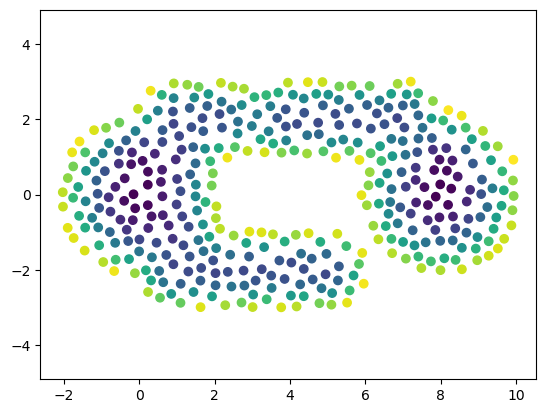

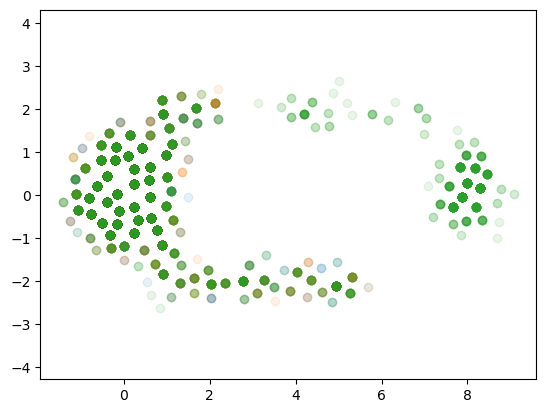

In [6]:
minima_coords   = [[0,0],[8,0],[0,1],  [1,1],  [1,2],  [2,2],  [3,2],  [4,2],  [5,2],  [6,2],  [7,2],  [8,1],  [0,-1], [1,-1], [1,-2], [2,-2], [3,-2], [4,-2], [5,-2]]
minima_energies = [[0,1],[0,1],[1,0.3],[1,0.3],[1,0.3],[1,0.3],[2,0.3],[1,0.3],[1,0.3],[1,0.3],[1,0.3],[1,0.3],[2,0.3],[1,0.3],[1,0.3],[1,0.3],[1,0.3],[1,0.3],[1,0.3]]
state_density = 200
kT = .4
noise_spectrum = "TBD"
threshold = 0.01 #note that this is a population threshold at the reference temperature, not an energy threshold
min_spacing = 0.3

#find the average distance to the 7th or 8th nearest neighbor and use that as a threshold for MSM construction
#set the base timescale to be very short so that only the nearest neighbors matter and then multiply that MSM by itself to get a TPM for timescales of interest
#employ sparse matrices for efficient propagation

xi_all, pi_all, e_all, pi_all_out, box_min, box_max = build_landscape(2, minima_coords, minima_energies, state_density, kT, threshold, min_spacing, noise_spectrum)
plot_synthetic_landscapes(xi_all, pi_all, e_all, pi_all_out, box_min, box_max, minima_coords, False, True, False, True, True)
dtmsm = synthetic_msm(xi_all, e_all, min_spacing, kT)

dt_sfreq = 100

init_coord = np.argmin([np.linalg.norm(xii-[0,0]) for xii in xi_all])

trj_coords = propagate_msm(dtmsm, kT, [init_coord, init_coord, init_coord], dt_sfreq, 20000, dt_sfreq)
for trjc in trj_coords:
    plt.scatter(trjc[:,0], trjc[:,1], alpha=0.1)
    plt.axis("equal")

# print(max(e_all))
# print(min(e_all))
# print(np.exp(-(min(e_all)-max(e_all))/kT))

In [7]:

dtmsm = deeptime.markov.msm.MarkovStateModel(trm.transpose(), stationary_distribution=None, reversible=None, n_eigenvalues=None, ncv=None, count_model=None, transition_matrix_tolerance=1e-08, lagtime=None)

dtsd = dtmsm.stationary_distribution
for si, s in enumerate(dtsd):
    plt.scatter([xi_all[si][0]], [xi_all[si][1]], c=[s], cmap='viridis')
    plt.clim(0,.1)
    plt.axis("equal")
plt.show()

dt_trj = dtmsm.simulate(1000000, seed=0)
#print(dt_trj)

trj_coords = np.array([xi_all[dti] for dti in dt_trj])

plt.plot(trj_coords[:,0], trj_coords[:,1])

NameError: name 'trm' is not defined

In [8]:
#calculate time evolution using MSM

init_state = np.zeros([trm.shape[0], 1])
init_state[0,0] = 1

state_t = init_state
for i in range(10):
    for si, s in enumerate(state_t):
        plt.scatter([xi_all[si][0]], [xi_all[si][1]], c=[s], cmap='viridis')
        plt.clim(0,.1)
    plt.show()
    state_t = np.matmul(np.matrix(trm)**1000, state_t)
    print(sum(state_t))


NameError: name 'trm' is not defined

In [ ]:
dtsd = dtmsm.stationary_distribution
for si, s in enumerate(dtsd):
    plt.scatter([xi_all[si][0]], [xi_all[si][1]], c=[s], cmap='viridis')
    plt.clim(0,.1)
plt.show()

In [ ]:
dt_trj = dtmsm.simulate(100000, seed=0)
#print(dt_trj)

trj_coords = np.array([xi_all[dti] for dti in dt_trj])

plt.plot(trj_coords[:,0], trj_coords[:,1])
# for si, s in enumerate(dt_trj):
#     plt.scatter([xi_all[s][0]], [xi_all[s][1]], c=[s], cmap='viridis')
#     plt.clim(0,.1)

In [ ]:
np.min(trm, axis=0)

In [8]:
import importlib
import analysis
import energy_landscapes_gaussian
import propagators

importlib.reload(energy_landscapes_gaussian)
importlib.reload(propagators)
importlib.reload(analysis)
import matplotlib.pyplot as plt

sys1g = energy_landscapes_gaussian.two_wells_decoy_valley()

input_r = [sys1g.standard_init_ind for i in range(10)]

trj_coords, trj_inds = propagators.propagate_msm(sys1g, None, input_r, 100, 10000, 100) 

#TODO: write a method to plot equilibrium populations as colored dots and sampled population estimates as colored rings around them, colored on the same scale

#estimate populations by a histogram
inds, counts = np.unique(trj_inds, return_counts=True) #[:,40000:]
x_sampled = sys1g.x[inds]
est_pops = [sci/sum(counts) for sci in counts]

#plot landscape
analysis.plot_synth_landscape(sys1g, x_sampled, est_pops)





AttributeError: 'two_wells_decoy_valley' object has no attribute 'standard_init_ind'

In [ ]:
################################################################################################################

In [10]:
def plot_synth_landscape(sys, x_sampled, est_pops):

    plt.figure(figsize=(10, 10))

    vmi = min(sys.p+est_pops)
    vma = max(sys.p+est_pops)
    print(vma)
    print(max(sys.p))
    print(sum(sys.p))

    #for tc, ep in zip(trj_coords, est_pops):
    plt.scatter(x_sampled[:,0], x_sampled[:,1], c=est_pops, vmin=0, vmax = vma, s=100)
    plt.scatter(x_sampled[:,0], x_sampled[:,1], c="white", s=50)
    plt.scatter(sys.x[:,0], sys.x[:,1], c=sys.p, vmin=0, vmax = vma, s=20) #cmap='viridis', 

    plt.axis("equal")


    plt.show()
plot_synth_landscape(sys1g, x_sampled, est_pops)


NameError: name 'sys1g' is not defined

In [27]:
trj_coords.shape

(3, 10000, 2)

In [40]:
np.array(sys1g.x)

array([[ 5.82928045e+00, -1.52041346e+00],
       [ 7.10047609e+00,  9.00154154e-01],
       [ 1.00693917e+01, -1.69922526e-01],
       [ 2.48805274e+00,  1.31588982e+00],
       [ 7.54670682e+00,  1.40115294e+00],
       [ 6.47200732e-01, -2.55091478e+00],
       [ 4.14320313e+00,  1.26284754e+00],
       [ 4.42693500e+00, -2.07249161e+00],
       [ 5.32037618e-01, -1.71545486e+00],
       [ 6.04858760e-02, -5.09346312e-01],
       [ 1.27670194e+00,  1.59308078e+00],
       [-1.17560351e+00, -1.69506069e+00],
       [ 7.94834851e+00,  1.13473677e+00],
       [ 9.60570406e+00, -4.62319260e-01],
       [ 6.75434430e+00, -6.70416396e-01],
       [-1.05127375e+00, -1.23488191e+00],
       [ 7.03634434e+00,  2.25427651e+00],
       [ 9.46199175e+00,  1.32483964e+00],
       [ 4.23279223e+00, -2.52280979e+00],
       [ 4.76173043e+00, -1.52838213e+00],
       [ 7.54648920e+00, -6.05242487e-01],
       [ 6.04927968e+00, -2.32561286e-01],
       [-1.23551992e+00, -8.64465566e-01],
       [ 3.

In [ ]:
#state_counts = np.zeros(len(sys1g.x))
#for ind, count in zip(inds, counts):
#    state_counts[ind] = count

# print(state_counts)
# plt.hist(state_counts)
# plt.show()

# for trji in trj_inds:
#     for j in range(len(sys1g.x)):
#         state_counts += trji.count(j)




# print(state_counts)

# plot_synthetic_landscapes(sys1g.x, sys1g.p_ref_temp, sys1g.e, sys1g.p, sys1g.box_min, sys1g.box_max, sys1g.minima_coords, False, True, False, True, True)

# for trjc in trj_coords:
#     plt.scatter(trjc[:,0], trjc[:,1], alpha=0.1)
#     plt.axis("equal")

# for minimum in sys1g.minima_coords:
#     plt.scatter(minimum[0], minimum[1], color="black")